# FrozenLake [4x4 | no random map | on slip]

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt

plt.style.use('dark_background')

# seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch device:", device)

Pytorch device: cuda


### Model

In [43]:
class FrozenLakeV0(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=16):
        super(FrozenLakeV0, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            # nn.Linear(hidden_size, hidden_size),
            # nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.network(x)

## Replay Buffer

In [44]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

## Agent

In [45]:
class DQNAgent:
    def __init__(self, modelClass, state_size, action_size, lr=1e-3, gamma=0.99,
                 buffer_size=10000, batch_size=64, target_update=100):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update

        # Q-network and target network
        self.q_net = modelClass(state_size, action_size).to(device)
        self.target_net = modelClass(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        # Sync target network
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.memory = ReplayBuffer(buffer_size)
        self.step_count = 0

    def act(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(state)
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.BoolTensor(dones).to(device)

        # current q-values
        current_q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # next q-values frm target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))

        # compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network periodically
        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())


## Training Loop

In [72]:
def one_hot_state(s, size):
    vec = np.zeros(size)
    vec[s] = 1.0
    return vec


def train_dqn(modelClass, env_name="FrozenLake-v1", is_slippery=False, episodes=2000, max_steps=100,
              no_progress_log=False):
    env = gym.make(env_name, is_slippery=is_slippery, render_mode=None)
    state_size = env.observation_space.n
    action_size = env.action_space.n  # 4 (left, down, right, up)

    agent = DQNAgent(modelClass=modelClass, state_size=state_size, action_size=action_size)

    scores = deque(maxlen=100)  # for moving average
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995

    epsilon = epsilon_start

    # Track metrics for plotting
    avg_rewards = []
    epsilons = []

    if not no_progress_log:
        print("Starting training...")
    for episode in range(episodes):
        state, _ = env.reset()
        state = one_hot_state(state, state_size)
        total_reward = 0

        for t in range(max_steps):
            action = agent.act(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # FrozenLake gives sparse reward: 1 only if goal reached
            # Optionally add small negative reward for steps to encourage speed
            # reward = reward - 0.01  # optional shaping

            next_state = one_hot_state(next_state, state_size)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()

            state = next_state
            total_reward += reward

            if done:
                break

        scores.append(total_reward)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        # Log every episode for smooth plot
        avg_score = np.mean(scores)
        avg_rewards.append(avg_score)
        epsilons.append(epsilon)

        if episode % 100 == 0 and not no_progress_log:
            print(f"Episode {episode}, Avg Reward (last 100): {avg_score:.3f}, Epsilon: {epsilon:.3f}")

    env.close()

    return agent, env, (avg_rewards, epsilons)


def evaluate_agent(agent, env, episodes=10, max_steps=100):
    state_size = env.observation_space.n

    success = 0
    for _ in range(episodes):
        state, _ = env.reset()
        state = one_hot_state(state, state_size)
        for _ in range(max_steps):
            action = agent.act(state, epsilon=0.0)  # greedy
            state, reward, terminated, truncated, _ = env.step(action)
            state = one_hot_state(state, state_size)
            if terminated or truncated:
                if reward == 1.0:
                    success += 1
                break
    print(f"\nSuccess rate over {episodes} episodes: {success}/{episodes} ({100 * success / episodes:.1f}%)")

Starting training...
Episode 0, Avg Reward (last 100): 0.000, Epsilon: 0.995
Episode 100, Avg Reward (last 100): 0.030, Epsilon: 0.603
Episode 200, Avg Reward (last 100): 0.250, Epsilon: 0.365
Episode 300, Avg Reward (last 100): 0.660, Epsilon: 0.221
Episode 400, Avg Reward (last 100): 0.830, Epsilon: 0.134
Episode 500, Avg Reward (last 100): 0.880, Epsilon: 0.081
Episode 600, Avg Reward (last 100): 0.930, Epsilon: 0.049
Episode 700, Avg Reward (last 100): 0.950, Epsilon: 0.030
Episode 800, Avg Reward (last 100): 0.980, Epsilon: 0.018
Episode 900, Avg Reward (last 100): 0.990, Epsilon: 0.011
Episode 1000, Avg Reward (last 100): 0.980, Epsilon: 0.010
Episode 1100, Avg Reward (last 100): 0.990, Epsilon: 0.010
Episode 1200, Avg Reward (last 100): 1.000, Epsilon: 0.010
Episode 1300, Avg Reward (last 100): 1.000, Epsilon: 0.010
Episode 1400, Avg Reward (last 100): 0.980, Epsilon: 0.010
Episode 1500, Avg Reward (last 100): 1.000, Epsilon: 0.010
Episode 1600, Avg Reward (last 100): 0.990, Eps

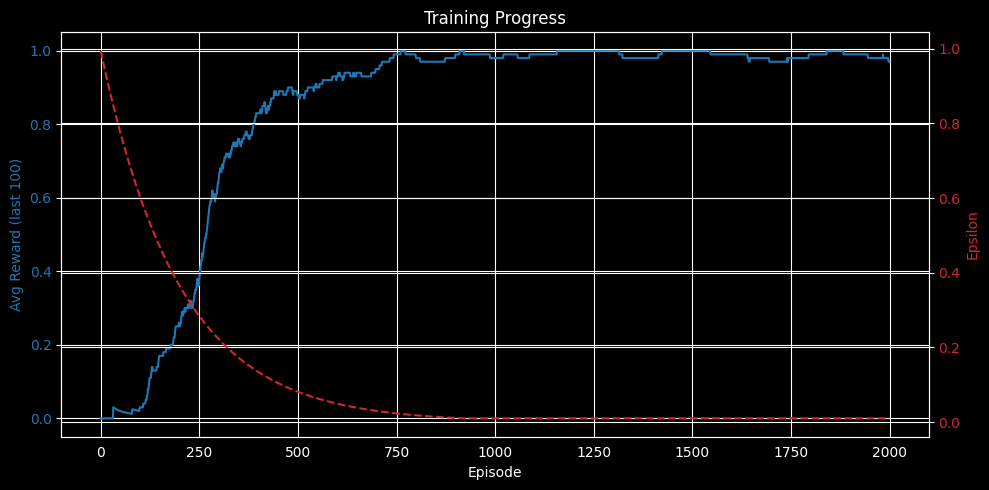

In [73]:
agent, env, (avg_rewards, epsilons) = train_dqn(modelClass=FrozenLakeV0, is_slippery=False, episodes=2000)

# Plotting
print(f"\\nModel: {FrozenLakeV0.__name__}", agent.q_net)
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Avg Reward (last 100)', color=color)
ax1.plot(avg_rewards, color=color, label='Avg Reward')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Epsilon', color=color)
ax2.plot(epsilons, color=color, label='Epsilon', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Progress')
fig.tight_layout()
plt.show()

In [60]:
eval_env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="human")
evaluate_agent(agent, eval_env, episodes=3)
eval_env.close()


Success rate over 3 episodes: 3/3 (100.0%)


## training over time for Various Layer/HiddenSize

LayersCount: 0  |  HiddenFeatCount: 2  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=4, bias=True)
)


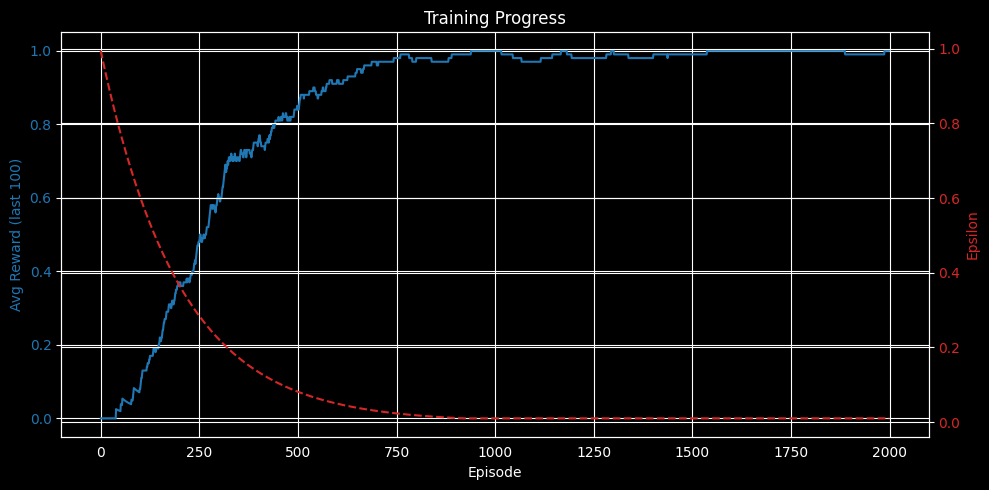

LayersCount: 1  |  HiddenFeatCount: 2  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=4, bias=True)
)


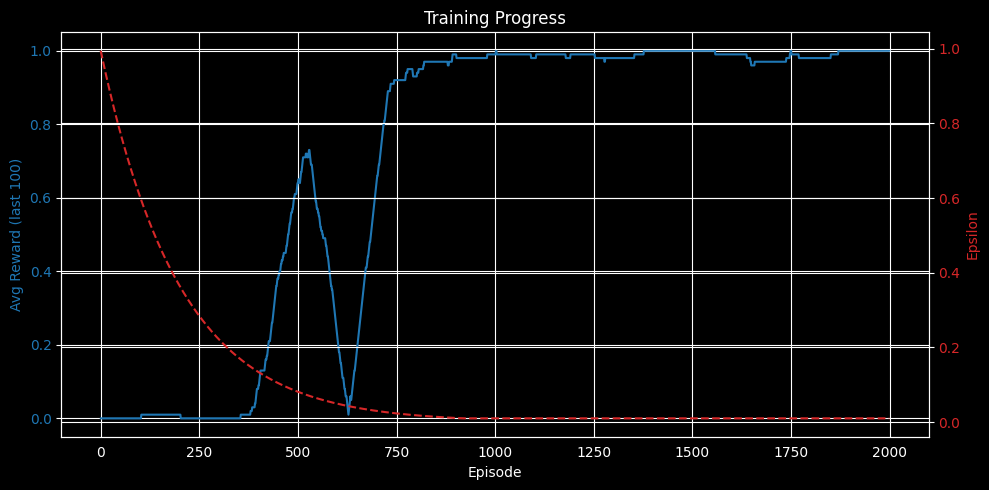

LayersCount: 1  |  HiddenFeatCount: 4  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
)


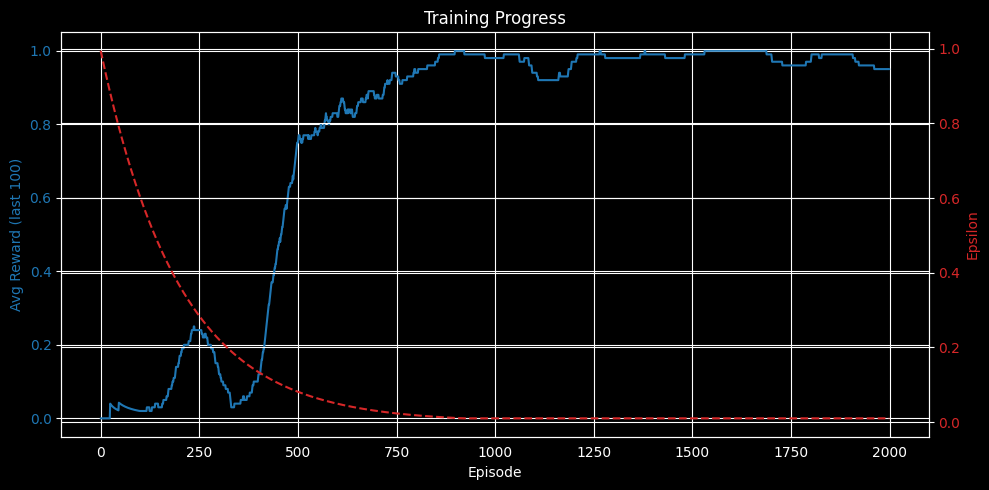

LayersCount: 1  |  HiddenFeatCount: 8  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
)


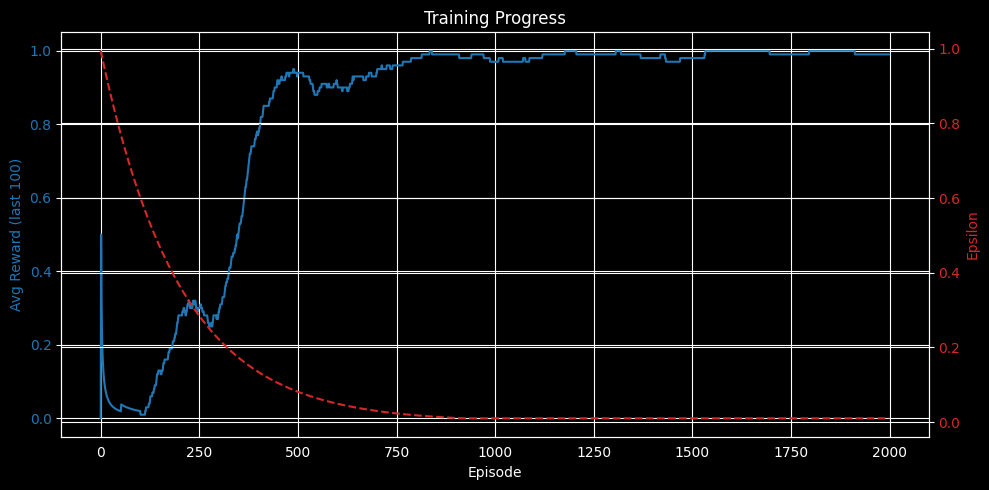

LayersCount: 1  |  HiddenFeatCount: 16  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=4, bias=True)
)


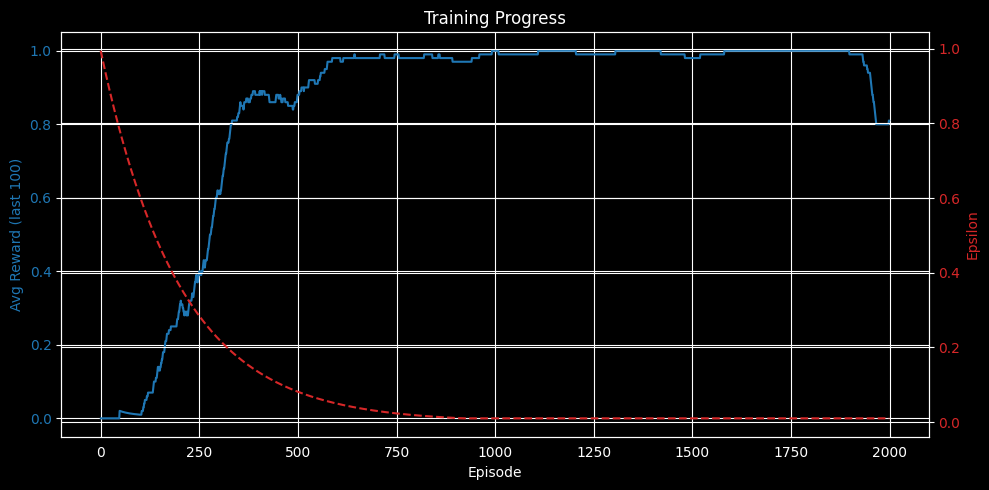

LayersCount: 1  |  HiddenFeatCount: 32  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=4, bias=True)
)


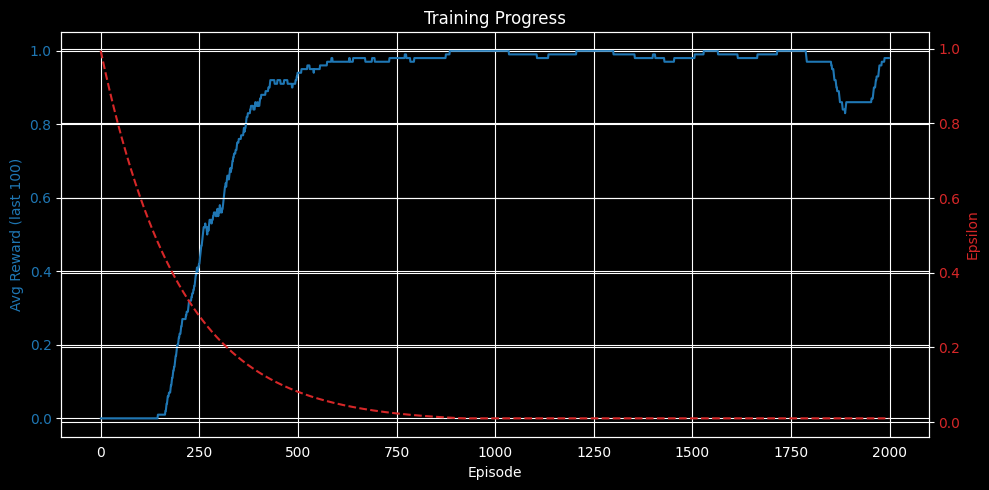

LayersCount: 1  |  HiddenFeatCount: 64  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=4, bias=True)
)


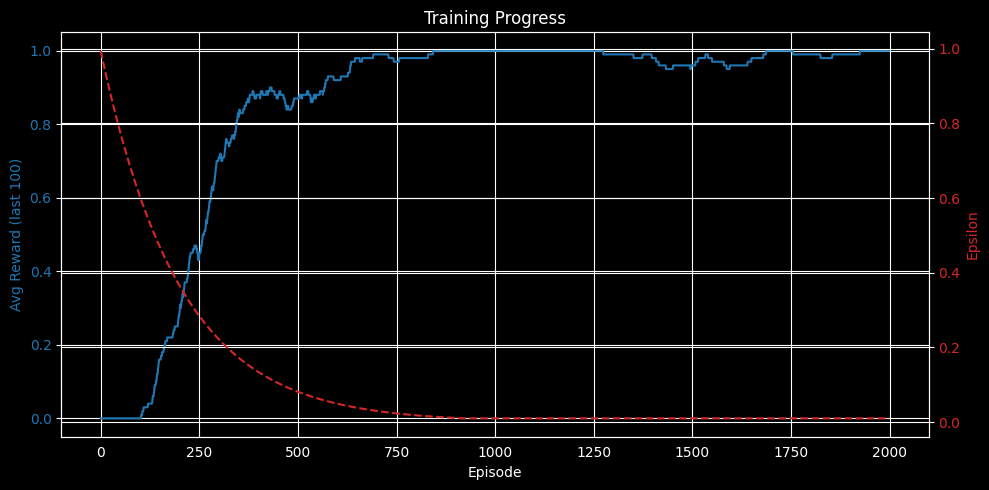

LayersCount: 1  |  HiddenFeatCount: 128  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=4, bias=True)
)


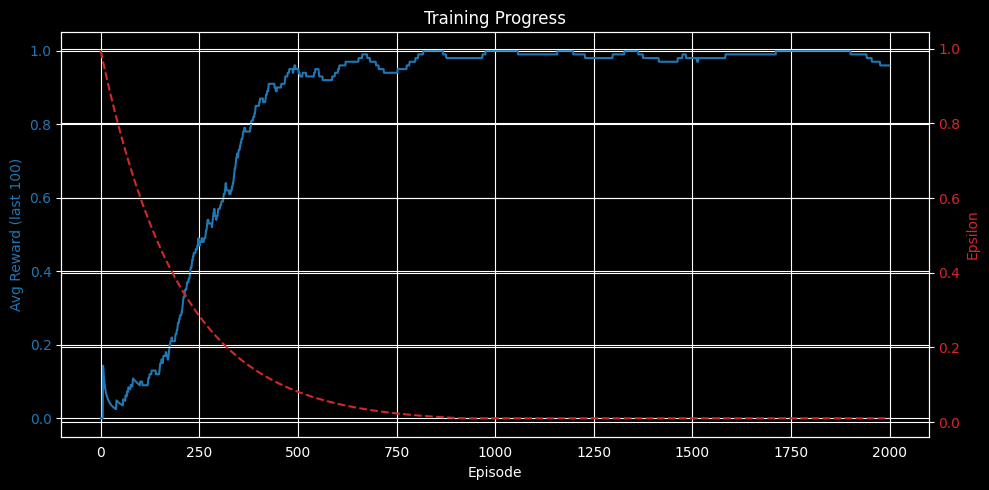

LayersCount: 1  |  HiddenFeatCount: 256  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=4, bias=True)
)


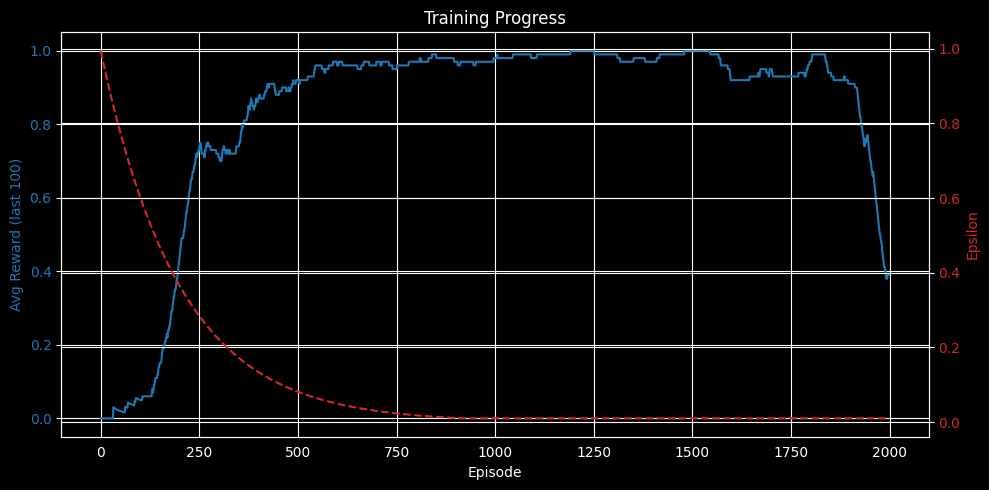

LayersCount: 2  |  HiddenFeatCount: 2  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=4, bias=True)
)


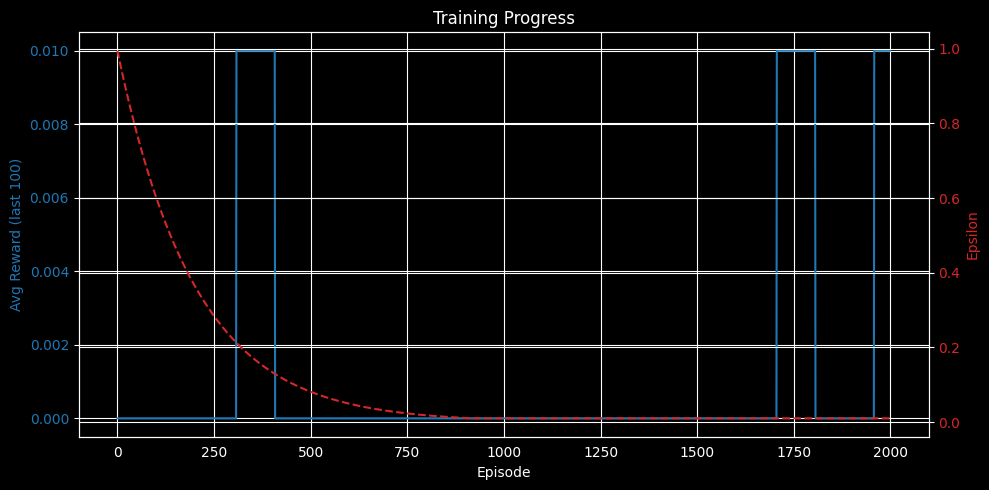

LayersCount: 2  |  HiddenFeatCount: 4  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=4, bias=True)
)


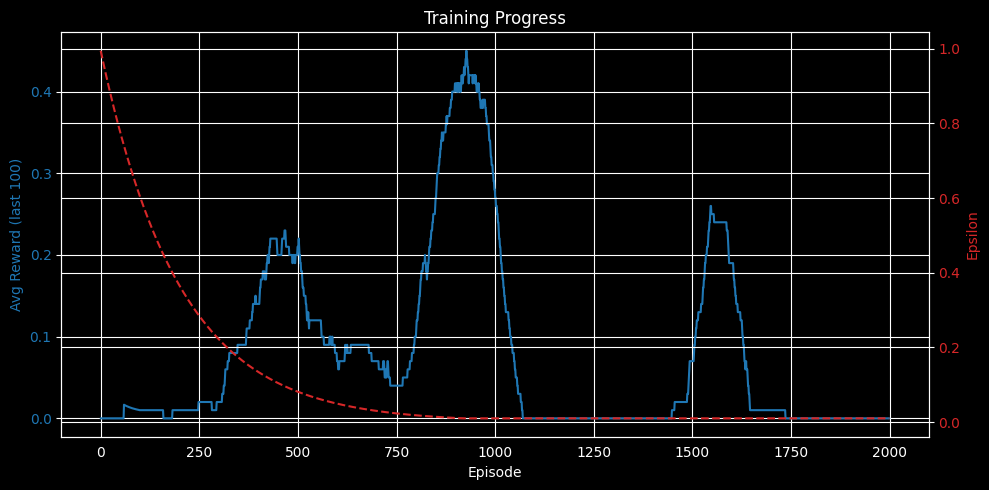

LayersCount: 2  |  HiddenFeatCount: 8  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=4, bias=True)
)


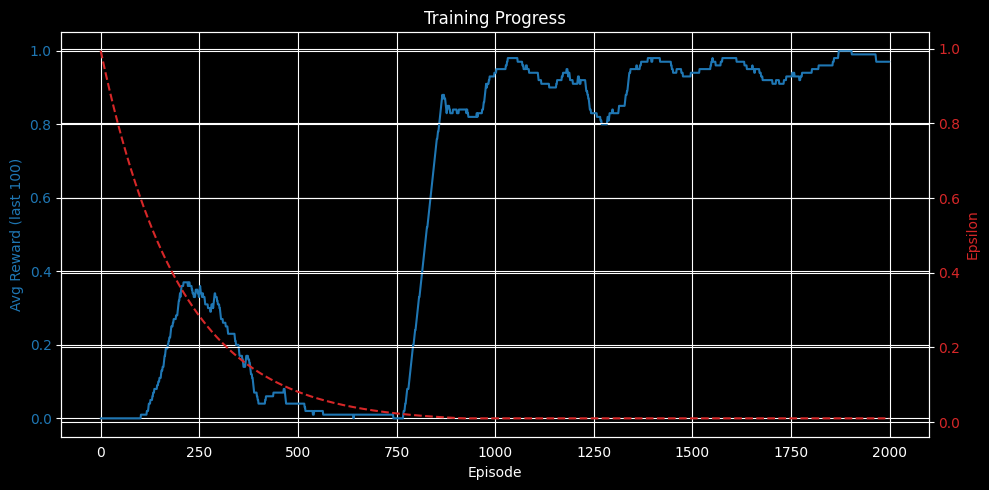

LayersCount: 2  |  HiddenFeatCount: 16  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=4, bias=True)
)


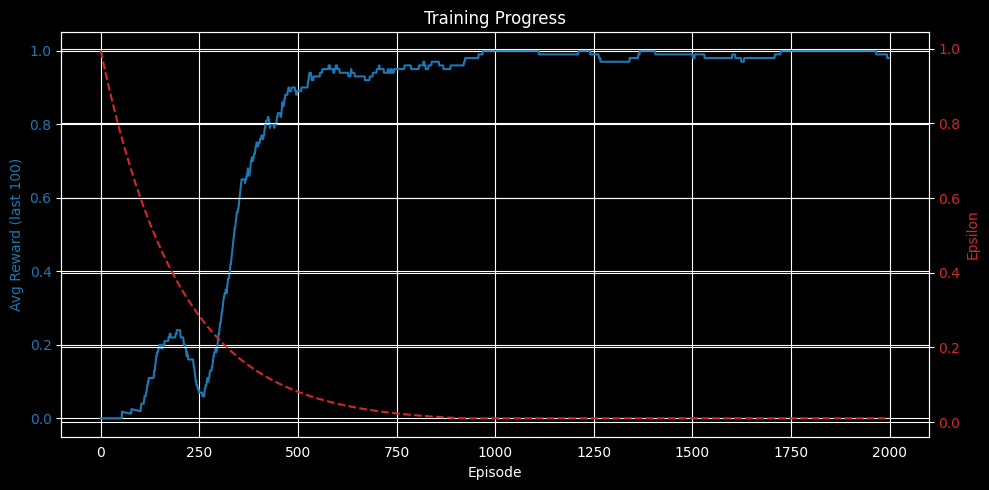

LayersCount: 2  |  HiddenFeatCount: 32  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=4, bias=True)
)


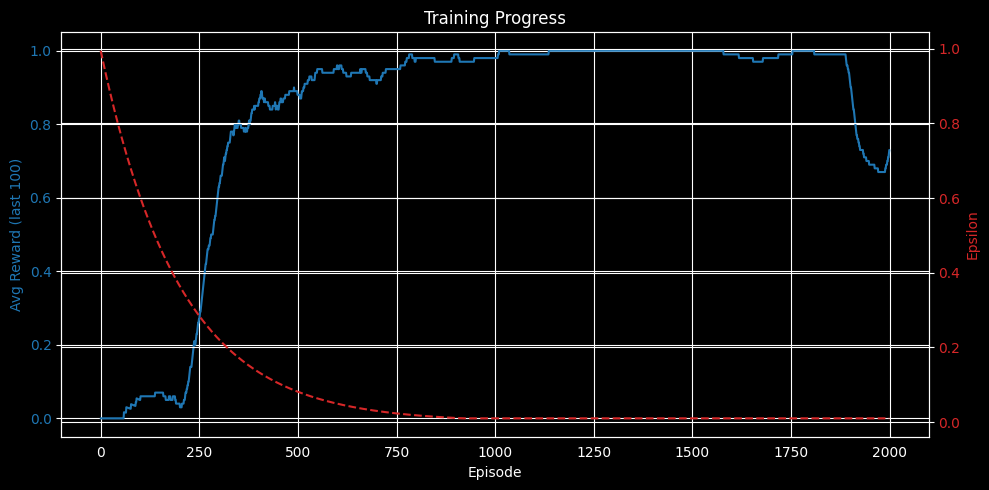

LayersCount: 2  |  HiddenFeatCount: 64  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=4, bias=True)
)


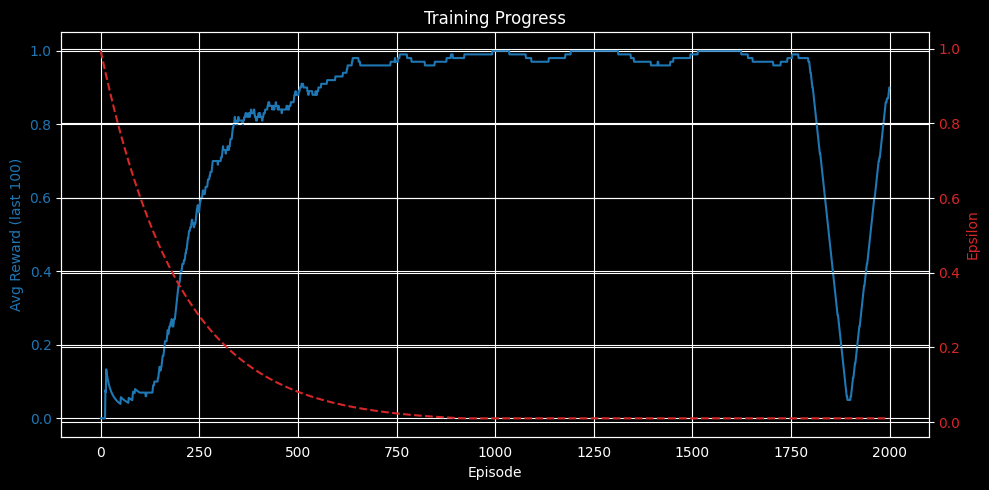

LayersCount: 2  |  HiddenFeatCount: 128  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=4, bias=True)
)


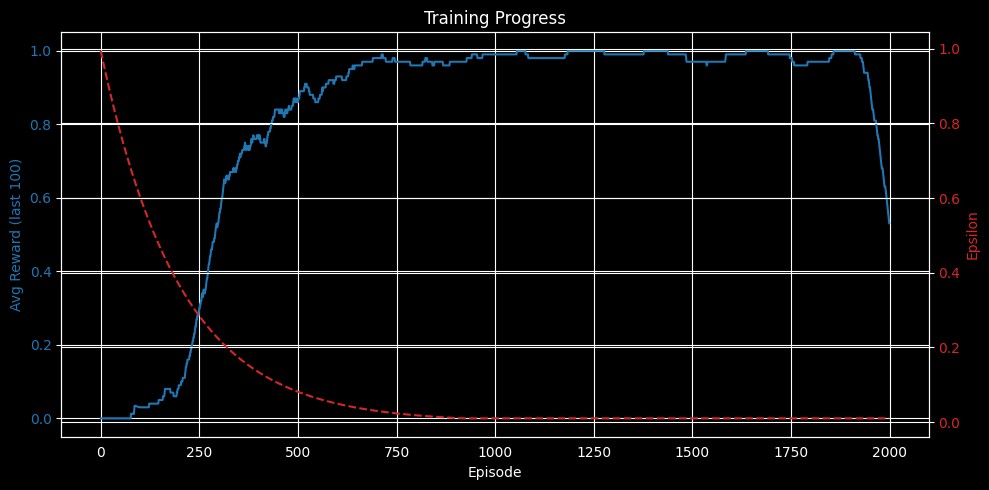

LayersCount: 2  |  HiddenFeatCount: 256  |  Model: FrozenLakeV1 Sequential(
  (0): Linear(in_features=16, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=4, bias=True)
)


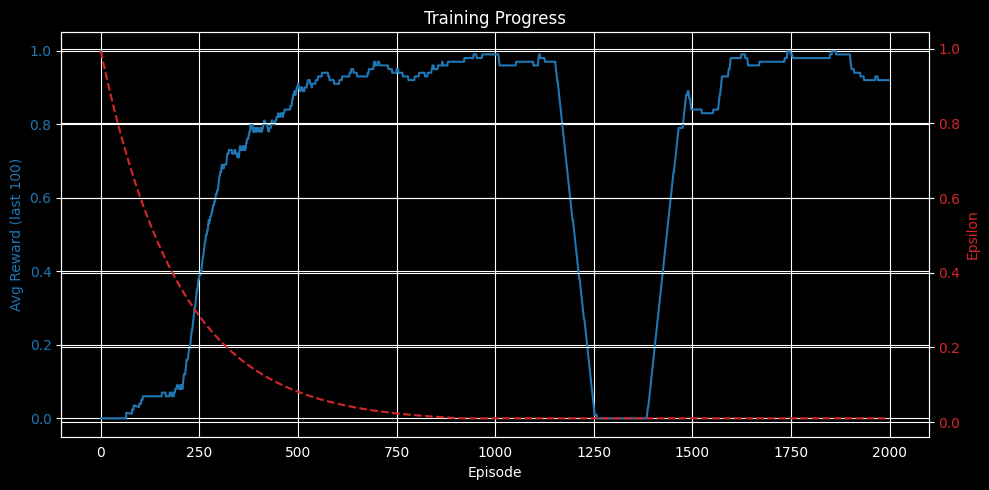

In [80]:
results = [
    # (layers, hidden_features, avg_rewards, epsilon),
]

for layer_count in range(3):
    for hidden_feat_count_pow in range(1, 9):
        hidden_feat_count = 2 ** hidden_feat_count_pow

        if layer_count == 0 and hidden_feat_count_pow > 1:
            continue


        class FrozenLakeV1(nn.Module):
            def __init__(self, state_size, action_size):
                super(FrozenLakeV1, self).__init__()
                self.network = nn.Sequential(
                    *((
                          nn.Linear(state_size, hidden_feat_count),
                          nn.ReLU()
                      ) if layer_count >= 1 else ()),
                    *((
                          nn.Linear(hidden_feat_count, hidden_feat_count),
                          nn.ReLU()
                      ) * (layer_count - 1) if layer_count > 1 else ()),

                    *((
                          nn.Linear(hidden_feat_count, action_size),
                      ) if layer_count >= 1 else (
                        nn.Linear(state_size, action_size),
                    )),
                )

                # print(self.network)

            def forward(self, x):
                return self.network(x)


        #!!DEBUG!!
        print(f"LayersCount: {layer_count}  |  HiddenFeatCount: {hidden_feat_count}  |  Model: {FrozenLakeV1.__name__}", FrozenLakeV1(16, 4).network)
        # continue

        agent, env, (avg_rewards, epsilons) = train_dqn(modelClass=FrozenLakeV1, is_slippery=False, episodes=2000,
                                                        no_progress_log=True)

        results.append((layer_count, hidden_feat_count, avg_rewards, epsilons))

        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 5))

        color = 'tab:blue'
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Avg Reward (last 100)', color=color)
        ax1.plot(avg_rewards, color=color, label='Avg Reward')
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Epsilon', color=color)
        ax2.plot(epsilons, color=color, label='Epsilon', linestyle='--')
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title('Training Progress')
        fig.tight_layout()
        plt.show()

In [83]:
import pickle

# # Load
# with open("files/frozenlake_dqn_sweep_results-1.pkl", "rb") as f:
#     results = pickle.load(f)
# print(f"Loaded {len(results)} experiment records.")

# Save
with open("files/frozenlake_dqn_sweep_results-1.pkl", "wb") as f:
    pickle.dump(results, f)
print("Results saved to files/frozenlake_dqn_sweep_results-1.pkl")

Results saved to files/frozenlake_dqn_sweep_results-1.pkl


LayersCount: 0  |  HiddenFeatCount: 2  |  Model: FrozenLakeV2 Sequential(
  (0): Linear(in_features=16, out_features=4, bias=True)
)


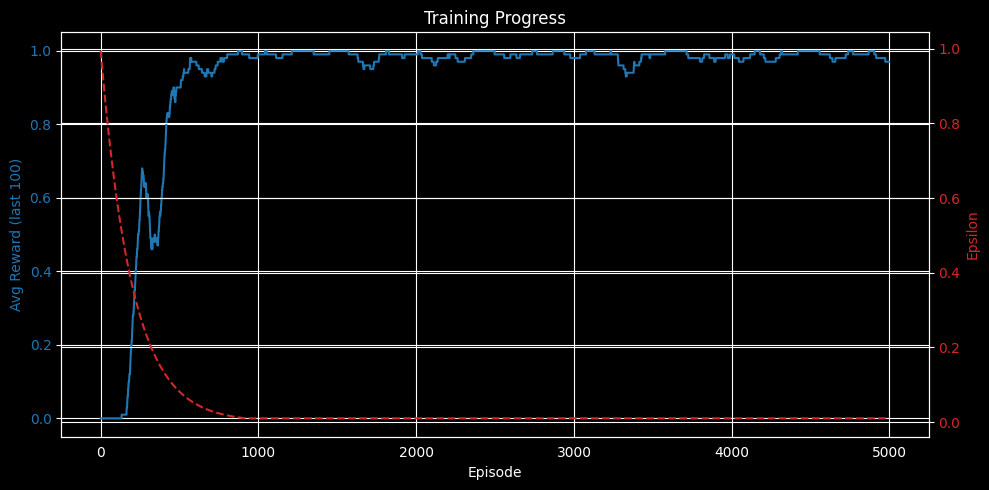

LayersCount: 1  |  HiddenFeatCount: 2  |  Model: FrozenLakeV2 Sequential(
  (0): Linear(in_features=16, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=4, bias=True)
)


In [ ]:
results = [
    # (layers, hidden_features, avg_rewards, epsilon),
]

for layer_count in range(8):
    for hidden_feat_count_pow in range(1, 10):
        hidden_feat_count = 2 ** hidden_feat_count_pow

        if layer_count == 0 and hidden_feat_count_pow > 1:
            continue


        class FrozenLakeV2(nn.Module):
            def __init__(self, state_size, action_size):
                super(FrozenLakeV2, self).__init__()
                self.network = nn.Sequential(
                    *((
                          nn.Linear(state_size, hidden_feat_count),
                          nn.ReLU()
                      ) if layer_count >= 1 else ()),
                    *((
                          nn.Linear(hidden_feat_count, hidden_feat_count),
                          nn.ReLU()
                      ) * (layer_count - 1) if layer_count > 1 else ()),

                    *((
                          nn.Linear(hidden_feat_count, action_size),
                      ) if layer_count >= 1 else (
                        nn.Linear(state_size, action_size),
                    )),
                )

                # print(self.network)

            def forward(self, x):
                return self.network(x)


        #!!DEBUG!!
        print(f"LayersCount: {layer_count}  |  HiddenFeatCount: {hidden_feat_count}  |  Model: {FrozenLakeV2.__name__}", FrozenLakeV2(16, 4).network)
        # continue

        agent, env, (avg_rewards, epsilons) = train_dqn(modelClass=FrozenLakeV2, is_slippery=False, episodes=5000,
                                                        no_progress_log=True)

        results.append((layer_count, hidden_feat_count, avg_rewards, epsilons))

        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 5))

        color = 'tab:blue'
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Avg Reward (last 100)', color=color)
        ax1.plot(avg_rewards, color=color, label='Avg Reward')
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Epsilon', color=color)
        ax2.plot(epsilons, color=color, label='Epsilon', linestyle='--')
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title('Training Progress')
        fig.tight_layout()
        plt.show()

In [ ]:
import pickle

# # Load
# with open("files/frozenlake_dqn_sweep_results-1.pkl", "rb") as f:
#     results = pickle.load(f)
# print(f"Loaded {len(results)} experiment records.")

# Save
with open("files/frozenlake_dqn_sweep_results-1.pkl", "wb") as f:
    pickle.dump(results, f)
print("Results saved to files/frozenlake_dqn_sweep_results-1.pkl")